 # GOLUB use case

In [1]:
library("evaluomeR") 
library("clusterAnalysis")
library("cancerclass")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("reshape2")
library("mclust")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

In [2]:
getRversion()
packageVersion("clusterAnalysis")

[1] '4.4.1'

[1] '0.0.0.9000'

# Table of contents
* [Dataset](#dataset)
    * [Top 200](#top)
* [Cest](#clest)
    * [RSKC](#rskc)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
data("golub")
dataset = golub
colnames(dataset)[colnames(dataset) == 'Case'] <- 'Description'
head(dataset)
dataset["Class"] = NULL
set.seed(13626)

,Description,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,⋯,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,⋯,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
2,T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,⋯,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
3,T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,⋯,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
4,B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,⋯,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
5,B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,⋯,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
6,T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,⋯,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


In [4]:
level_mapping <- c("B" = 1, "T" = 2, "M" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(golub["Class"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3

Three types of classes within the dataset: **B**, **T** and **M**.

# Clest <a class="anchor" id="clest"></a>
Execution of Clest over the previous dataset.

In [5]:
dataset_matrix = as.matrix(dataset[, -1])
clest_result = clusterAnalysis::clest(dataset_matrix, maxK=10, pmax=0.05, dmin=0.05, B=20,B0=20,
                                      clusterAlg=myPam, rho=2/3, similarity=dendextend::FM_index_R, verbose=FALSE)
message(paste0("Clest optimal k: ", clest_result$kopt))

Clest optimal k: 3



In [6]:
pa = cluster::pam(dataset_matrix, clest_result$kopt)
predicted = pa$clustering

In [7]:
dataset["Cluster"] = as.factor(as.numeric(predicted))
pca_matrix = dataset %>% select(-Cluster)
r_pca = evaluomeR::performPCA(dataset = pca_matrix)
pca_df = r_pca$dataset_ncp
pca_df$Cluster <- as.factor(dataset$Cluster)
pca_df$Description <- dataset$Description

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 19



Warning message:
"The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


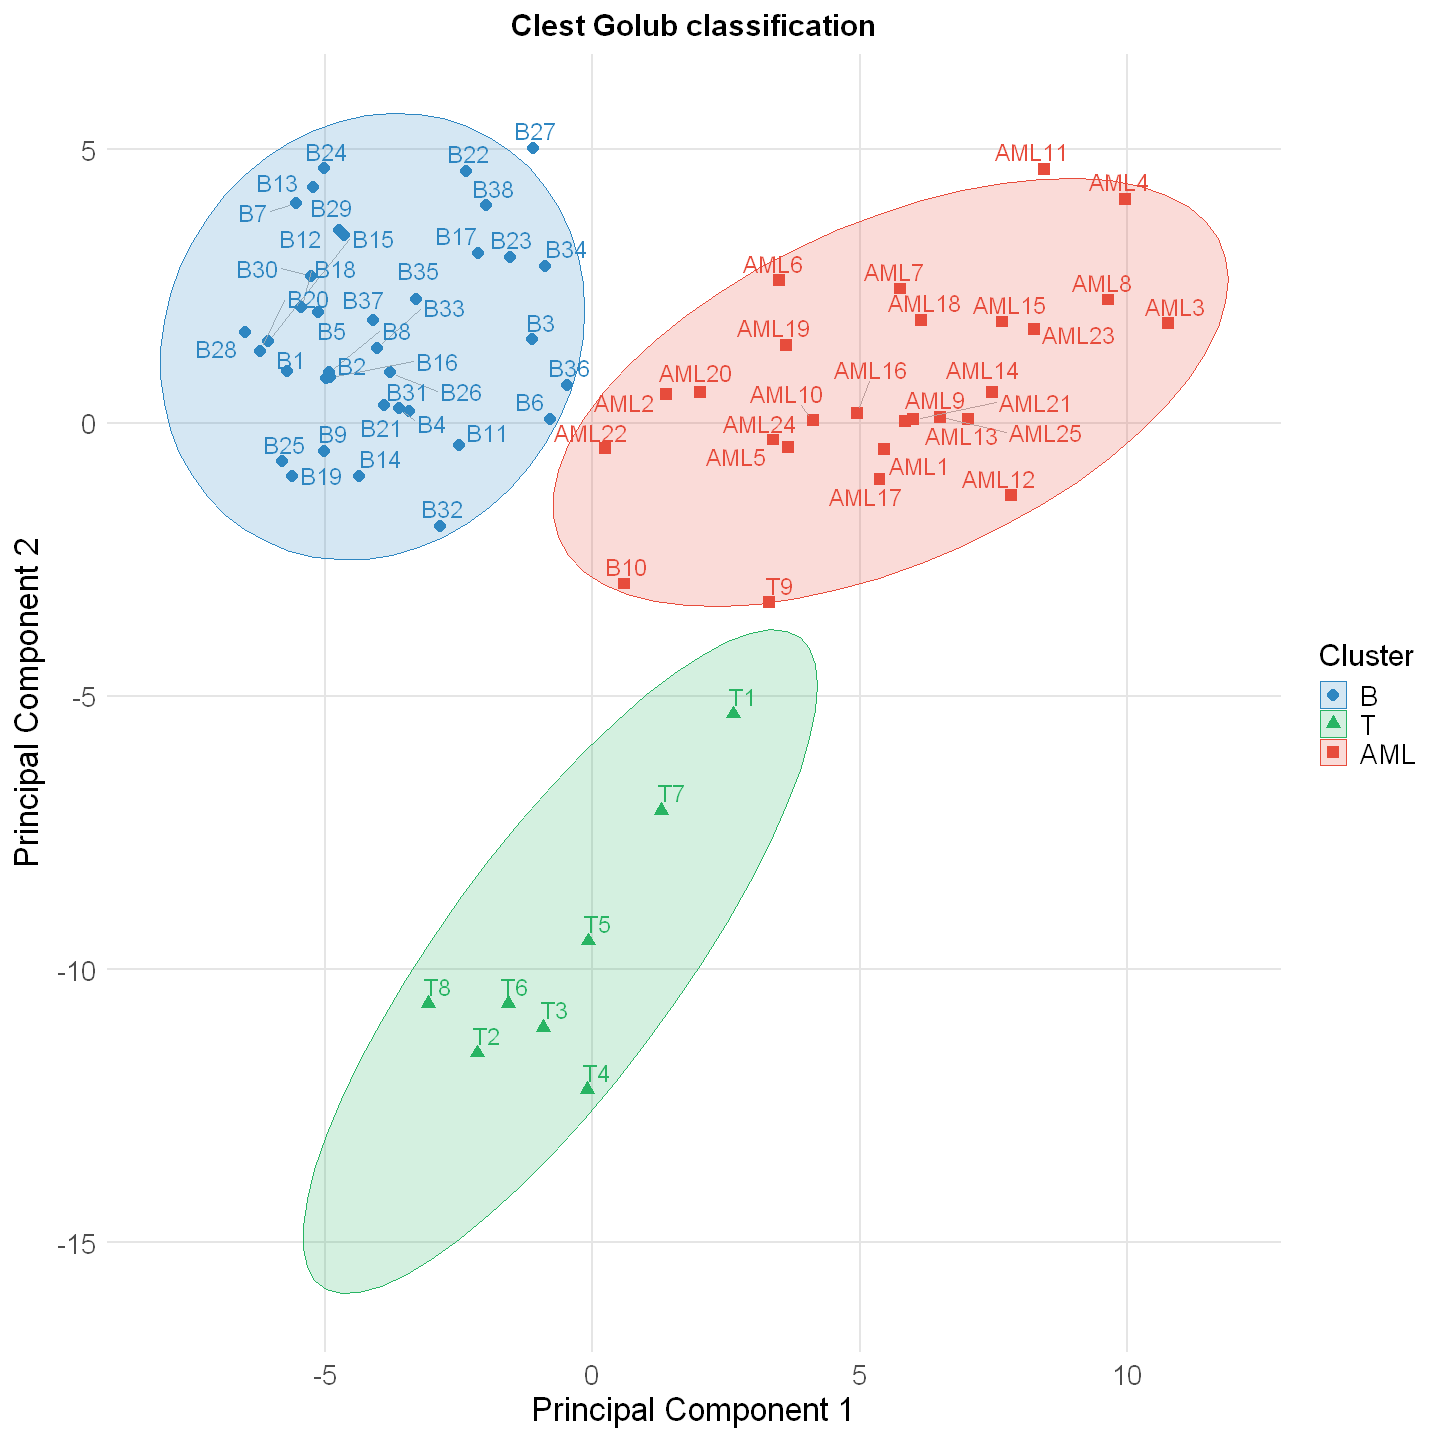

In [8]:
cluster_colors =  c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#f95d6a", 
                                    "#7F8C8D", "#FF5733", "#8E44AD", "#003f5c", "#ffa600")

cluster_shapes = c(16, 17, 15, 18, 19)
cluster_labels = c("B", "T", "AML")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = Cluster, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 5,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 10,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster, group = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "Clest Golub classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels)  +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels)   +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )

In [16]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,1,2,3
,<chr>,<chr>,<chr>
Sensitivity. (%),97,89,100


[1] "(97,89,100)"

In [10]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 3.76%"


In [11]:
clest_result$d

[1] 0.2542743 0.3553637 0.2326284 0.2387503 0.2336491 0.1577587 0.1441187
[8] 0.1067317 0.1375746

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


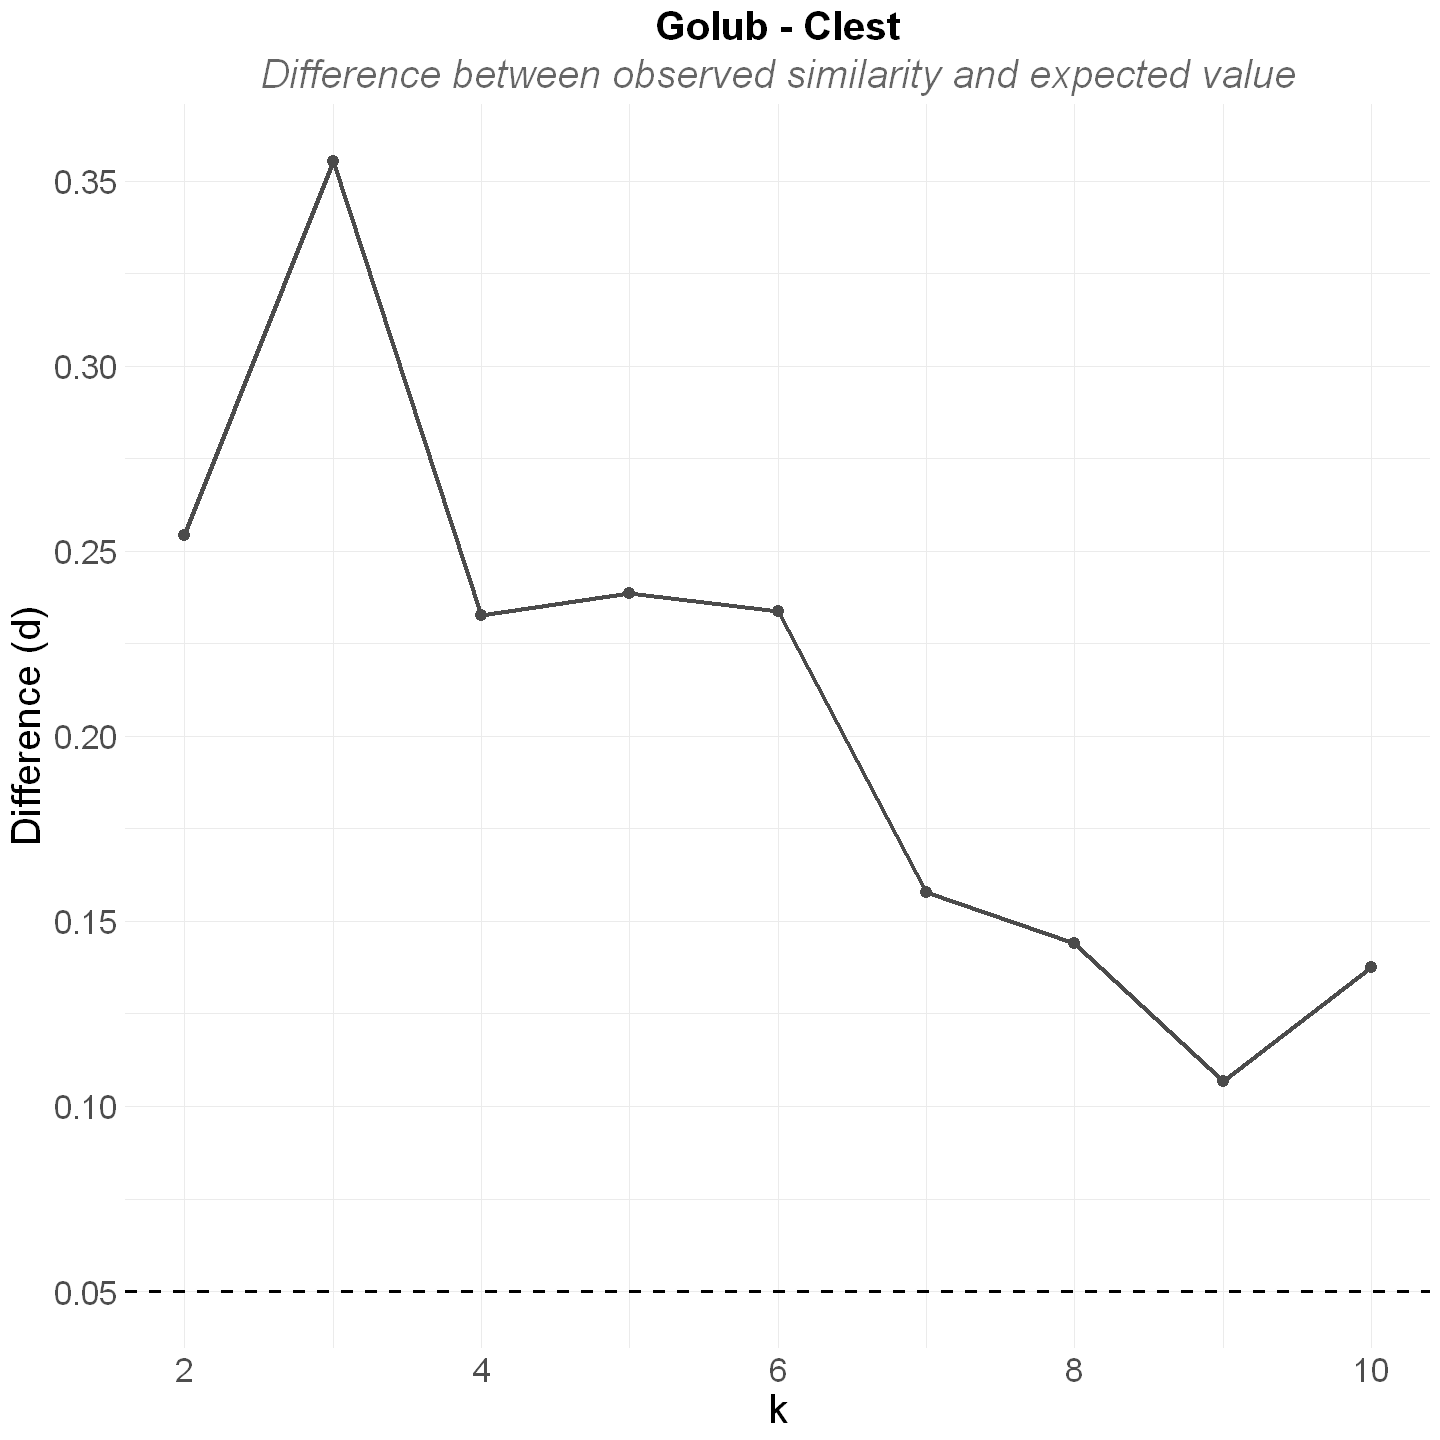

In [12]:
df <- data.frame(K = c(2:10), 
                 Difference = clest_result$d)

ggplot(df, aes(x = K, y = Difference)) +
  geom_line(color = "#4B4B4B", size = 1.2) +
  geom_point(size = 3, color = "#4B4B4B") +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "black", size = 1) +
  scale_y_continuous(breaks = seq(0, max(df$Difference) + 0.05, by = 0.05)) +
  labs(title = "Golub - Clest",
       subtitle = "Difference between observed similarity and expected value",
       x = "k", 
       y = "Difference (d)") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 24, face = "italic", color = "gray40"),
    legend.position = "right",
    legend.title = element_text(size = 24),
    legend.text = element_text(size = 20),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    axis.text = element_text(size = 20)
  )

In [13]:
#ModelExplorer(, 10, similarity=dendextend::FM_index_R, clusterAlg = myPam, rho = 2/3, B = 100, verbose = FALSE)
#Gap(dataset_matrix, maxK=10, clusterAlg = myPam, B = 20, null_distrib = "uniform", verbose = TRUE)
mean(silhouette(pa$clustering, dist(dataset_matrix))[,3])

[1] 0.2320141